# Titanic data set

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from cohortshapley import dataset
from cohortshapley import realistic
from cohortshapley import sampling
from cohortshapley import similarity
from cohortshapley import baselineshapley as bs
from cohortshapley import cohortshapley as cs
from cohortshapley import similarity
from cohortshapley import figure
from cohortshapley import varianceshapley as vs

## Load data

In [2]:
X,Y,categorical = dataset.titanic()

## Train logistic regression model

In [3]:
from sklearn.linear_model import LogisticRegression

def simple_logistic_regression(X,Y):
    # generate prediction model using Logistic Regression
    model = LogisticRegression(random_state=0).fit(X.values, Y.flatten())
    f = lambda x: model.predict_proba(x).T[1].reshape(-1,1)
    return model, f

In [4]:
model, f = simple_logistic_regression(X,Y)

In [5]:
subject_id = list(range(len(X.index)))
subject = X.values[subject_id]
baseline = np.array([np.mean(subject, axis=0)])

## Variance Shapley (Shapley effects) for global explanation

In [6]:
# compute variance Shapley with simple binning
similarity.bins = 10
vs_values = vs.VarianceShapley(f(X.values),similarity.binning(X.values)[0])

In [7]:
order=np.argsort(vs_values)[::-1]

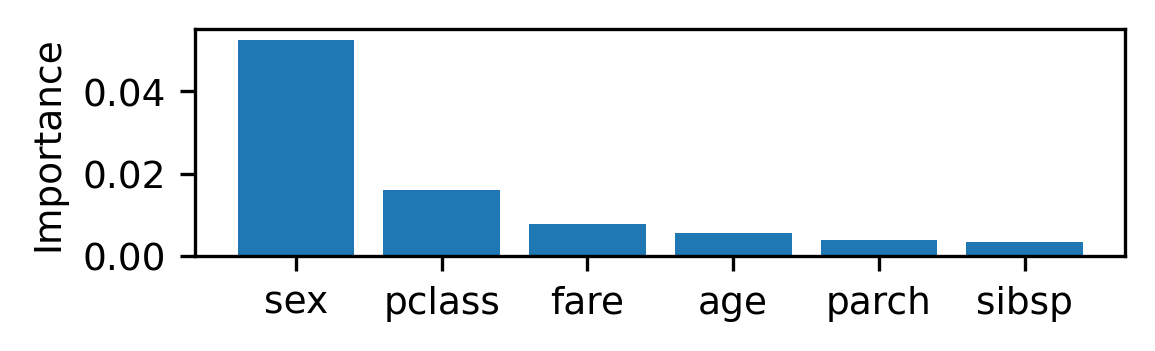

In [8]:
fig=plt.figure(figsize=(4, 1),dpi=300)
plt.rcParams["font.size"] = 9
plt.bar(X.columns[order],vs_values[order])
plt.ylabel('Importance')
plt.show()

## Cohort Shapley for local explanation

In [9]:
# set distance threashold for similarity function
similarity.ratio=0.1
# compute cohort Shapley value
cs_obj = cs.CohortShapley(f, similarity.similar_in_distance_cutoff, subject_id, X.values, parallel=4)
cs_obj.compute_cohort_shapley()

use given model to predict y.
parallel processing with 4 processes
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.
use given y values instead of model prediction.


100%|██████████| 262/262 [00:13<00:00, 19.64it/s]


In [10]:
# create result directory and save (& load)
import os
if not os.path.isdir('result'):
    os.mkdir("result")

cs_obj.save('result/titanic_cs01')
cs_obj.load('result/titanic_cs01')

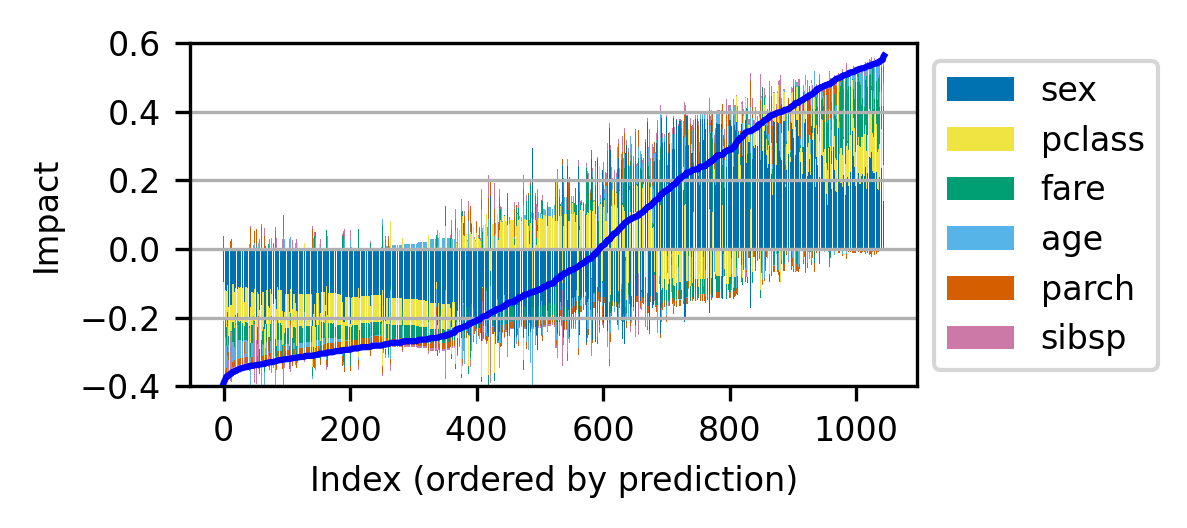

In [11]:
# draw figure of aggregated Shapley values in stacked bar plots for all subjects
figure.set_colorblind_palette()
fig = plt.figure(figsize=(4,1.8),dpi=300)
plt.rcParams["font.size"] = 8
figure.draw_aggregate_graph(cs_obj.shapley_values, X.columns, f(subject), order=order)
plt.ylim(-0.4,0.6)
plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.tight_layout()
plt.show()
figure.set_color_palette('tab10')

## Comparison with baseline Shapley, all baseline Shapley, and squared versions

In [12]:
similarity.ratio=0.1
bs_obj = bs.BaselineShapley(f, subject, baseline, eval_realistic=True, similarity = similarity.similar_in_distance, data=X.values)
bs_obj.compute_baseline_shapley()
bs_obj.save('result/titanic_bsmean')
bs_obj.load('result/titanic_bsmean')

similarity.ratio=0.1
bs_obj2 = bs.BaselineShapley(f, subject, subject)
bs_obj2.compute_baseline_shapley()
bs_obj2.save('result/titanic_bsall')
bs_obj2.load('result/titanic_bsall')

similarity.ratio=0.1
bs_obj3 = bs.BaselineShapley(f, subject[0:1], subject, eval_realistic=True, similarity = similarity.similar_in_distance, data=X.values)
bs_obj3.compute_baseline_shapley()
bs_obj3.save('result/titanic_bsall2')
bs_obj3.load('result/titanic_bsall2')

100%|██████████| 1/1 [00:45<00:00, 45.34s/it]


## Aggregated Shapley values in stacked bar plots for all subjects

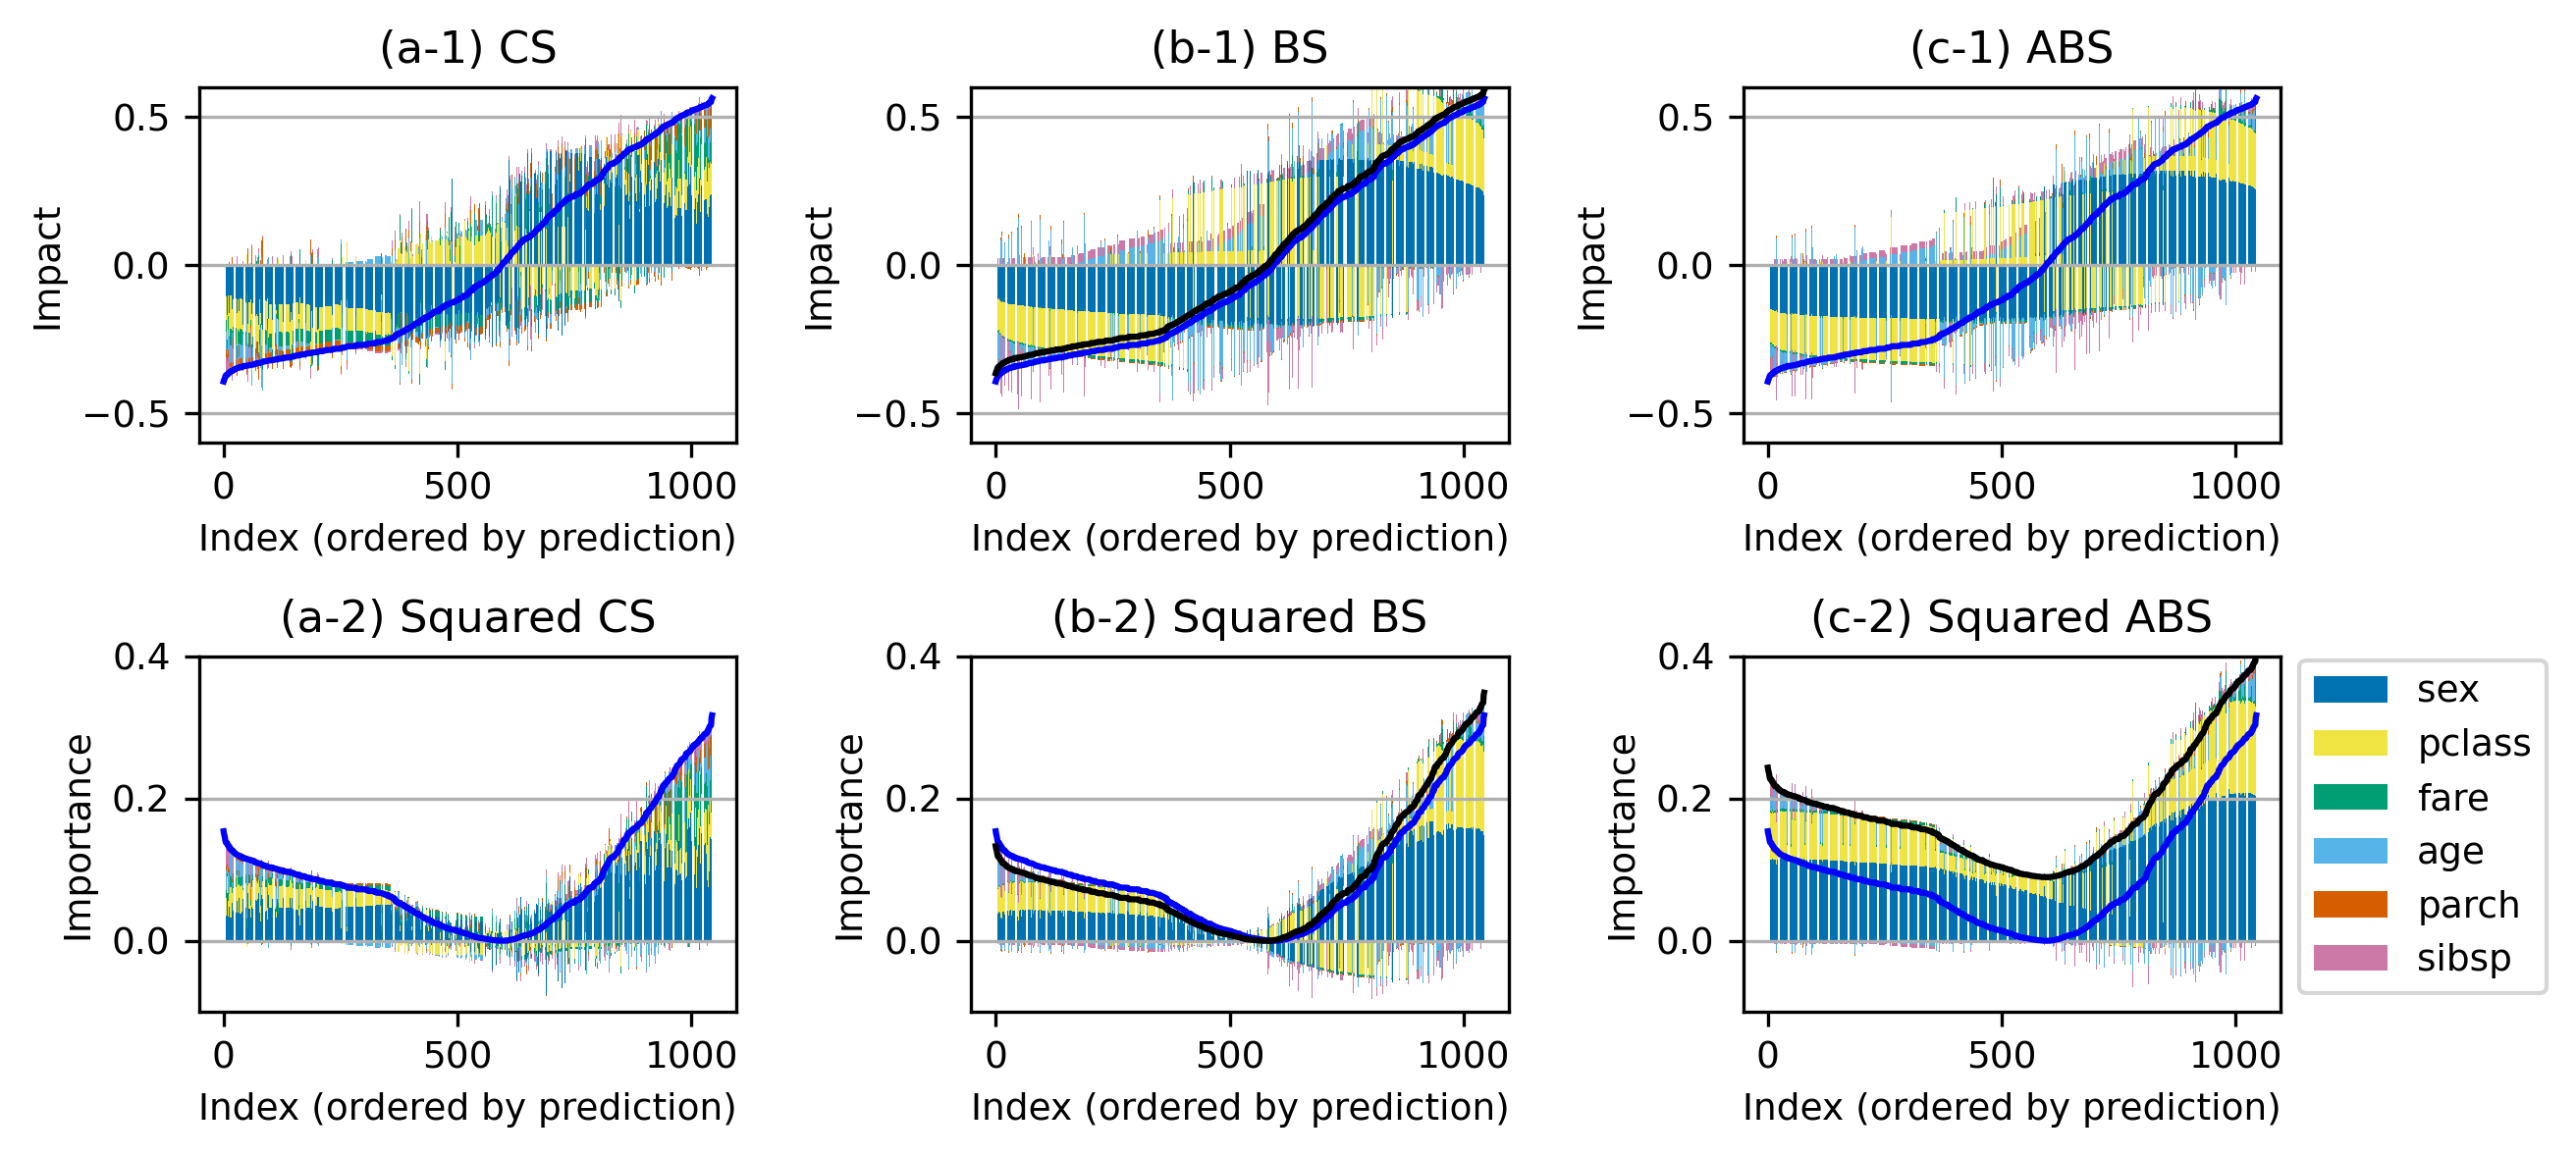

In [17]:
figure.set_colorblind_palette()
fig = plt.figure(figsize=(8,4),dpi=300)
plt.rcParams["font.size"] = 9

plt.subplot(2,3,1)
figure.draw_aggregate_graph(cs_obj.shapley_values, X.columns, f(subject), order=order)
plt.ylim(-0.6,0.6)
plt.title('(a-1) CS')

plt.subplot(2,3,4)
figure.draw_aggregate_graph2(cs_obj.shapley_values2, X.columns, f(subject), order=order)
plt.ylim(-0.1,0.4)
plt.title('(a-2) Squared CS')

plt.subplot(2,3,2)
figure.draw_aggregate_graph(bs_obj.shapley_values, X.columns, f(subject), base=bs_obj.base_value, order=order)
plt.ylim(-0.6,0.6)
plt.title('(b-1) BS')

plt.subplot(2,3,5)
figure.draw_aggregate_graph2(bs_obj.shapley_values2, X.columns, f(subject), base=bs_obj.base_value, order=order)
plt.ylim(-0.1,0.4)
plt.title('(b-2) Squared BS')

plt.subplot(2,3,3)
figure.draw_aggregate_graph(bs_obj2.shapley_values, X.columns, f(subject), order=order)
plt.ylim(-0.6,0.6)
plt.title('(c-1) ABS')

plt.subplot(2,3,6)
figure.draw_aggregate_graph2(bs_obj2.shapley_values2, X.columns, f(subject), multibase=True, order=order)
plt.ylim(-0.1,0.4)
plt.title('(c-2) Squared ABS')

plt.tight_layout()
plt.legend(bbox_to_anchor=(1,0), loc='lower left')
plt.show()
figure.set_color_palette('tab10')

### Realistic/unrealistic portion in baseline and all baseline Shapley for the 1st subject

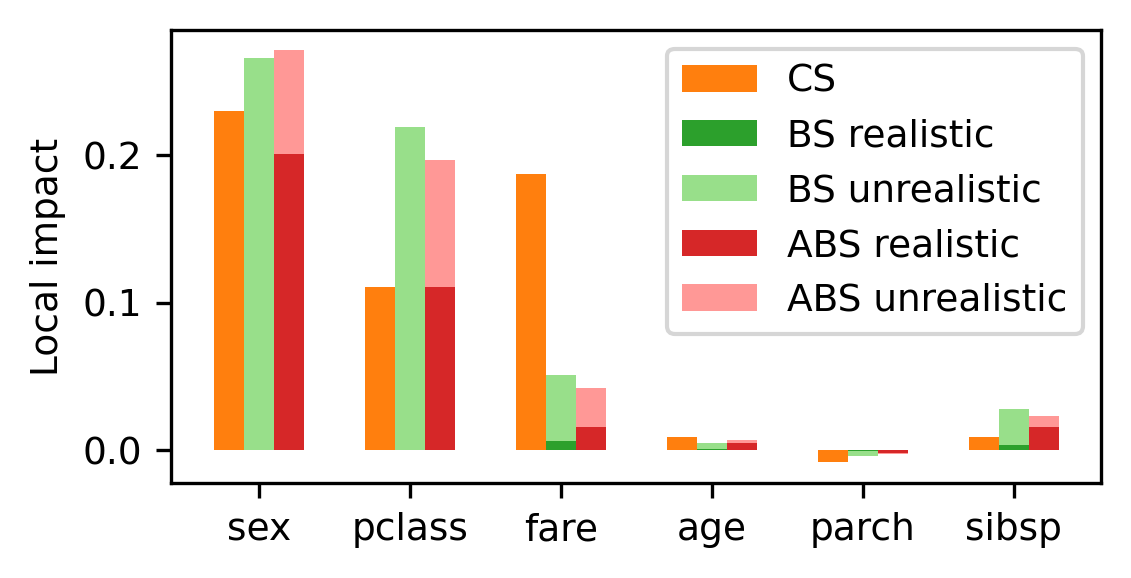

In [14]:
figure.set_color_palette('tab20')
fig=plt.figure(figsize=(4,2),dpi=300)
plt.rcParams["font.size"] = 9
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0)
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0)
plt.bar(np.arange(len(X.columns))-0.2,cs_obj.shapley_values[0][order],width=0.2,label='CS')
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0)
#
total = bs_obj.shapley_values[0][order]
realistic = bs_obj.shapley_values_realistic[0][order]
unrealistic = total - realistic
n_vars = len(realistic)
bar_l = np.zeros(n_vars)
bar_u = np.zeros(n_vars)
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, realistic)
plt.bar(np.arange(len(X.columns)),realistic,bottom=bottom,width=0.2,label='BS realistic')
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, unrealistic)
plt.bar(np.arange(len(X.columns)),unrealistic,bottom=bottom,width=0.2,label='BS unrealistic')
#
total = bs_obj3.shapley_values[0][order]
realistic = bs_obj3.shapley_values_realistic[0][order]
unrealistic = total - realistic
n_vars = len(realistic)
bar_l = np.zeros(n_vars)
bar_u = np.zeros(n_vars)
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, realistic)
plt.bar(np.arange(len(X.columns))+0.2,realistic,bottom=bottom,width=0.2,label='ABS realistic')
bar_l, bar_u, bottom = figure.calc_bottom(bar_l, bar_u, unrealistic)
plt.bar(np.arange(len(X.columns))+0.2,unrealistic,bottom=bottom,width=0.2,label='ABS unrealistic')
#
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0,tick_label=X.columns[order])
plt.ylabel('Local impact')
plt.axis('on')
plt.legend()
plt.plot()
figure.set_color_palette('tab10')

### Comparison of global explanation by squared versions

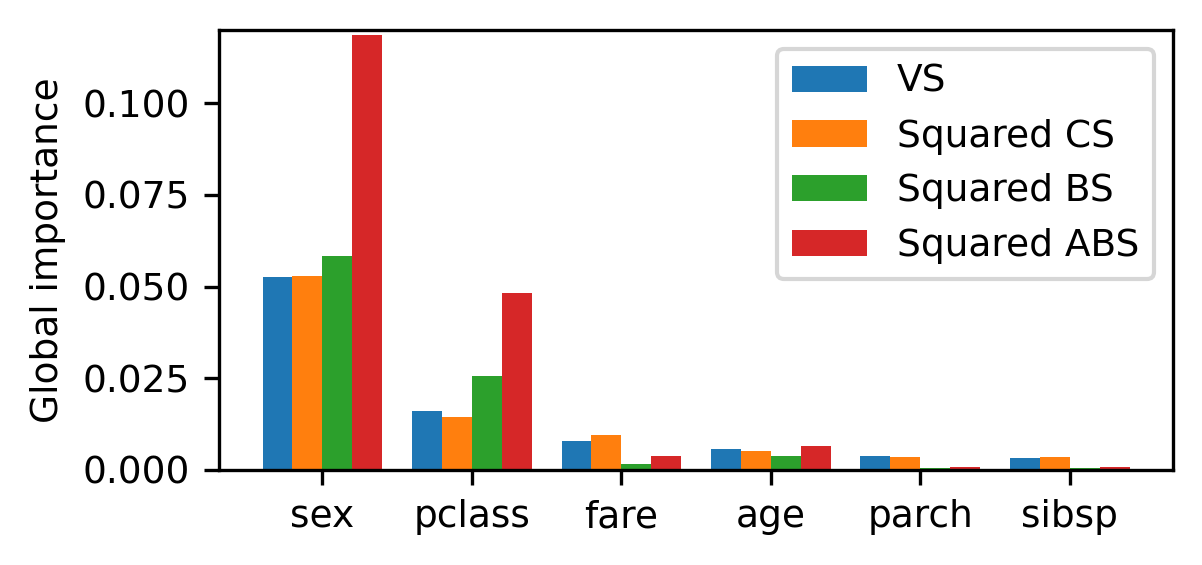

In [18]:
fig=plt.figure(figsize=(4,2),dpi=300)
plt.rcParams["font.size"] = 9

plt.ylim(0,0.12)
plt.bar(np.arange(len(X.columns))-0.3,vs_values[order],width=0.2,label='VS')
plt.bar(np.arange(len(X.columns))-0.1,cs_obj.shapley_values2.mean(axis=0)[order],width=0.2,label='Squared CS')
plt.bar(np.arange(len(X.columns))+0.1,bs_obj.shapley_values2.mean(axis=0)[order],width=0.2,label='Squared BS')
plt.bar(np.arange(len(X.columns))+0.3,bs_obj2.shapley_values2.mean(axis=0)[order],width=0.2,label='Squared ABS')
plt.bar(np.arange(len(X.columns)),np.zeros(len(X.columns)),width=0,tick_label=X.columns[order])
plt.ylabel('Global importance')
plt.legend()
plt.tight_layout()
plt.plot()
plt.show()